In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

import cv2
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


In [3]:
# tf.config.list_physical_devices('GPU')

In [4]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras import utils

### Getting Your data In

(48, 48, 3)


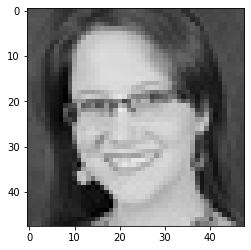

In [5]:
img_example = cv2.imread(r'..\face-expression-recognition-dataset\images\train\happy\7.jpg')
img_example
print(img_example.shape)
plt.imshow(img_example);

In [6]:
train_images_path = r'..\face-expression-recognition-dataset\fer_directory\Training'
valid_images_path = r'..\face-expression-recognition-dataset\fer_directory\Validation'

In [7]:
csv_path = r'..\face-expression-recognition-dataset\fer2013\fer2013.csv'

### Via Keras's ImageDataGeneratorClass

In [8]:
train_gen = ImageDataGenerator(rescale=1./255)
valid_gen = ImageDataGenerator(rescale=1./255)

In [9]:
aug_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.2, horizontal_flip=True)

In [10]:
# zoom_range=0.2, horizontal_flip=True, width_shift_range=0.2, height_shift_range=0.2

#### ImageDataGenerator Method 1:
`Flow From Directory`

In [11]:
train_flow = train_gen.flow_from_directory(train_images_path, color_mode='grayscale', target_size=(48, 48))

Found 28709 images belonging to 7 classes.


In [12]:
valid_flow = valid_gen.flow_from_directory(valid_images_path, color_mode='grayscale', target_size=(48, 48))

Found 3589 images belonging to 7 classes.


#### ImageDataGenerator Method 2:
`Flow (From Array)`

In [13]:
df = pd.read_csv(csv_path)

In [14]:
df.columns

Index(['emotion', 'pixels', 'Usage'], dtype='object')

In [15]:
df.Usage.unique()

array(['Training', 'PublicTest', 'PrivateTest'], dtype=object)

In [16]:
df['pixels'] = df.pixels.apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((48,48,1)))

3


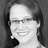

In [17]:
i = 7
print(df['emotion'][i])
array_to_img(df['pixels'][i].reshape((48,48,1)))

In [18]:
def convert_to_array(s):
    arr = np.array(list(s)).reshape((-1,48,48,1))
    return arr

In [19]:
cw = df[df.Usage=='Training'].emotion.value_counts()
class_weight_dict = dict(cw/sum(cw))

In [20]:
def train_val_test_split(data):
    train = data[data.Usage=='Training']
    val = data[data.Usage=='PublicTest']
    test = data[data.Usage=='PrivateTest']
    x_train, y_train = train['pixels'], train['emotion']
    x_val, y_val = val['pixels'], val['emotion']
    x_test, y_test = test['pixels'], test['emotion']
    return convert_to_array(x_train), convert_to_array(x_val), convert_to_array(x_test), utils.to_categorical(y_train, num_classes=7),  utils.to_categorical(y_val, num_classes=7),  utils.to_categorical(y_test, num_classes=7)

In [21]:
x_train, x_val, x_text, y_train, y_val, y_test = train_val_test_split(df)

In [22]:
aug_gen.fit(x_train)

In [23]:
Aug_flow = aug_gen.flow(x_train, y_train, batch_size=64)

In [24]:
val_flow = valid_gen.flow(x_val, y_val, batch_size=64)

### Via OpenCV2 & OS module

In [25]:
train_x, valid_x, train_y, valid_y = [], [], [], []

In [26]:
classes = [category for category in os.listdir(train_images_path)]

In [27]:
for category in os.listdir(train_images_path):
    cat_path = os.path.join(train_images_path, category)
    for image in os.listdir(cat_path):
        img_path = os.path.join(cat_path, image)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img, (48,48))
        train_x.append(img_array)
        train_y.append(classes.index(category))

In [28]:
train_y = utils.to_categorical(np.array(train_y), num_classes=7)

In [29]:
train_x = np.array(train_x).reshape(-1, 48, 48, 1)

In [30]:
train_x.shape

(28709, 48, 48, 1)

In [31]:
train_y.shape

(28709, 7)

In [32]:
for category in os.listdir(valid_images_path):
    cat_path = os.path.join(valid_images_path, category)
    for image in os.listdir(cat_path):
        img_path = os.path.join(cat_path, image)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img_array = cv2.resize(img, (48,48))
        valid_x.append(img_array)
        valid_y.append(classes.index(category))

In [33]:
valid_y = utils.to_categorical(np.array(valid_y), num_classes=7)

In [34]:
valid_x = np.array(valid_x).reshape(-1, 48, 48, 1)

### Models

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization,AveragePooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

In [36]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [37]:
BATCH_SIZE = 64
EPOCHS = 100

#### `Convulational NN Dropout`

Neural Network architecture implemented by [EmoPy](https://github.com/thoughtworksarts/EmoPy) a machine learning toolkit for emotional expression and described as [ConvulationalNNDropout](https://github.com/thoughtworksarts/EmoPy#convolutionalnndropout)

In [41]:
emo_model = Sequential()

emo_model.add(Conv2D(input_shape=train_flow.image_shape, filters=64, kernel_size=(3,3), activation='relu', data_format='channels_last', kernel_regularizer=l2(0.01)))
emo_model.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu', data_format='channels_last', padding='same'))
emo_model.add(BatchNormalization())
emo_model.add(MaxPooling2D(pool_size=(2,2)))
emo_model.add(Dropout(0.5))

emo_model.add(Conv2D(filters=128, kernel_size=(4,4), activation='relu', data_format='channels_last', padding='same'))
emo_model.add(BatchNormalization())
emo_model.add(Conv2D(filters=128, kernel_size=(4,4), activation='relu', data_format='channels_last', padding='same'))
emo_model.add(BatchNormalization())
emo_model.add(MaxPooling2D(pool_size=(2,2)))
emo_model.add(Dropout(0.5))

emo_model.add(Conv2D(filters=256, kernel_size=(4,4), activation='relu', data_format='channels_last', padding='same'))
emo_model.add(BatchNormalization())
emo_model.add(Conv2D(filters=256, kernel_size=(4,4), activation='relu', data_format='channels_last', padding='same'))
emo_model.add(BatchNormalization())
emo_model.add(MaxPooling2D(pool_size=(2,2)))
emo_model.add(Dropout(0.5))

emo_model.add(Flatten())

emo_model.add(Dense(train_flow.num_classes, activation="softmax"))


In [42]:
emo_model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), loss=categorical_crossentropy, metrics=['accuracy'])

In [43]:
emo_model.fit(train_flow, 
              epochs = 30, 
              steps_per_epoch = train_flow.n//train_flow.batch_size, 
              validation_data = valid_flow, 
              validation_steps = valid_flow.n//valid_flow.batch_size,
              callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=3)],
              shuffle=True,
              verbose=1)

Epoch 1/30
897/897 [==============================] - 27s 31ms/step - loss: 2.9930 - accuracy: 0.2454 - val_loss: 1.9304 - val_accuracy: 0.3337
Epoch 2/30
897/897 [==============================] - 29s 32ms/step - loss: 1.7088 - accuracy: 0.3691 - val_loss: 1.6297 - val_accuracy: 0.3873
Epoch 3/30
897/897 [==============================] - 28s 31ms/step - loss: 1.4439 - accuracy: 0.4488 - val_loss: 1.3561 - val_accuracy: 0.4880 - loss: 1.444
Epoch 4/30
897/897 [==============================] - 30s 33ms/step - loss: 1.3177 - accuracy: 0.5016 - val_loss: 1.3514 - val_accuracy: 0.4760TA: 0s - loss: 1.3179 - accuracy: 
Epoch 5/30
897/897 [==============================] - 29s 33ms/step - loss: 1.2387 - accuracy: 0.5338 - val_loss: 1.3091 - val_accuracy: 0.5089oss: 1.2377 - accu - ETA - ETA: 3s - ETA: 1s - loss: 1.2374 - accu - ETA: 0s - loss: 1.2382  - ETA: 0s - loss: 1.2381 - ac
Epoch 6/30
897/897 [==============================] - 29s 33ms/step - loss: 1.1729 - accuracy: 0.5620 - val_lo

In [45]:
emo_model_json = emo_model.to_json()
with open(r"..\Saved Models\fer_emo.json", "w") as json_file:
    json_file.write(emo_model_json)
emo_model.save_weights(r"..\Saved Models\fer_emo.h5")

#### `Custom VGG13 Network`

Neural Network architecture as described in the paper [Training Deep Networks for Facial Expression Recognition with Crowd-Sourced Label Distribution](https://arxiv.org/abs/1608.01041) (Barsoum et al.)  :
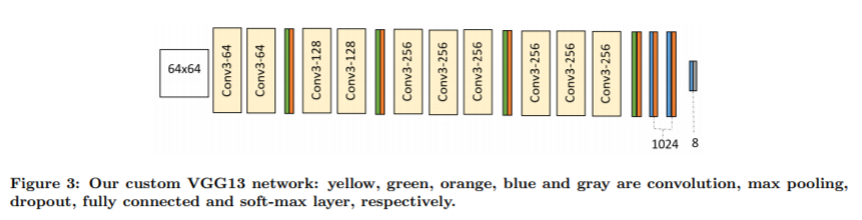

In [46]:
ms_model = Sequential()

ms_model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu', input_shape=train_flow.image_shape, kernel_regularizer=l2(0.01)))
ms_model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
ms_model.add(Dropout(0.25))

ms_model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
ms_model.add(Dropout(0.25))

ms_model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
ms_model.add(Dropout(0.25))

ms_model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
ms_model.add(BatchNormalization())
ms_model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2)))
ms_model.add(Dropout(0.25))

ms_model.add(Flatten())

ms_model.add(Dense(1024, activation='relu'))
# ms_model.add(Activation('relu'))
ms_model.add(Dropout(0.5))

ms_model.add(Dense(1024, activation='relu'))
# ms_model.add(Activation('relu'))
ms_model.add(Dropout(0.5))

# ms_model.add(Flatten())


ms_model.add(Dense(train_flow.num_classes, activation='softmax'))

In [47]:
ms_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), metrics=['accuracy'])

In [48]:
ms_model.fit(x_train, y_train, 
              epochs=EPOCHS, 
#               batch_size=BATCH_SIZE,
              steps_per_epoch=len(x_train)//BATCH_SIZE,
              validation_data = (x_val, y_val),
              validation_steps = len(x_val)//BATCH_SIZE,
              callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=3)],
              shuffle=True)

Epoch 1/100
448/448 [==============================] - 21s 48ms/step - loss: 2.0745 - accuracy: 0.2235 - val_loss: 1.8224 - val_accuracy: 0.2572 2.1211  - ETA: 0s - loss: 2.0822 
Epoch 2/100
448/448 [==============================] - 21s 47ms/step - loss: 1.7921 - accuracy: 0.2736 - val_loss: 1.8441 - val_accuracy: 0.2282s - los - ETA: 15s - loss: 1.8263 - accuracy - ETA: 15s - loss: 1.8234 - accuracy: - ETA: 14s - l - ETA: 7s - loss: 1.8060 - ac - ETA: 6s - loss: 1.8048 - accuracy: 0.26 - ETA:  - ETA: 4s - loss: 1.802
Epoch 3/100
448/448 [==============================] - 21s 47ms/step - loss: 1.7103 - accuracy: 0.3229 - val_loss: 2.6230 - val_accuracy: 0.1282loss: 1.726 - ETA: 12s - loss: 1.7327 - a - ETA: 6s - loss: - ETA: 3s
Epoch 4/100
448/448 [==============================] - 22s 49ms/step - loss: 1.5673 - accuracy: 0.3955 - val_loss: 1.4484 - val_accuracy: 0.4327
Epoch 5/100
448/448 [==============================] - 22s 50ms/step - loss: 1.4052 - accuracy: 0.4714 - val_loss: 1

In [49]:
ms_model_json = ms_model.to_json()
with open(r"..\Saved Models\fer_ms.json", "w") as json_file:
    json_file.write(ms_model_json)
ms_model.save_weights(r"..\Saved Models\fer_ms.h5")